# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

---
 Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**



In [1]:
# Load pickled data
import pickle
import os
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:

EPOCHS=20#40#20#10
BATCH_SIZE=1280#500#128

In [3]:


training_file = 'traffic-signs-data/train.p'
validation_file='traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

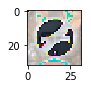

In [4]:
from matplotlib import pyplot as plt
plt.figure(figsize=(1,1))
plt.imshow((np.subtract(X_train[80],128)))
plt.show()

### Basic Summary of the Data Set 

In [5]:
n_train = len(y_train)

n_validation = len(y_valid)

n_test = len(y_test)

image_shape = X_train[0].shape


n_classes = len(set(y_train))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [6]:
def Convert_array_to_float(arr):
    arr=np.float32(arr)
    return arr
def Convert_images(X_train, X_valid, X_test):
    X_train=Convert_array_to_float(X_train)
    X_valid=Convert_array_to_float(X_valid)
    X_test=Convert_array_to_float(X_test)
    return X_train, X_valid, X_test


In [7]:
X_train, X_valid, X_test=Convert_images(X_train, X_valid, X_test)

### Include an exploratory visualization of the dataset

----

## Step 2: Design and Test a Model Architecture




In [8]:
from sklearn.utils import shuffle
X_train,y_train=shuffle(X_train,y_train)

2


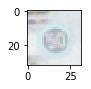

In [9]:
### Data exploration v
import matplotlib.pyplot as plt
import random 
# Visualizations will be shown in the notebook.
%matplotlib inline
index=random.randint(0,len(X_train))
image=X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])
#print(X_train[0])

In [10]:
def Add_Image_to_Array(imgarray,labels,image, image_class):
    image2=np.expand_dims(image,axis=0) #add a 0-indexed dimension thus it is now image[0] gives actual image
    #print(image2.shape)
    #print(imgarray.shape)
    imgarray=np.vstack((imgarray,image2)) #vertically stack image to image array
    labels=np.append(labels,image_class) #add label to existing vector of labels
    return imgarray, labels
def Balanced_Resampling(X,y, n_classes):
    ideal_ratio=1.0/n_classes
    act_ratio=np.histogram(y, len(set(y)))[0]/len(X) #gets the actual proportions of the data
    counts=np.histogram(y, len(set(y)))
    percent_of_train_data=(counts[0]/len(X))
    min_count=sorted(percent_of_train_data)[0]
    #flag_alteration=[0,1,2,3,4] #0: do nothing, 1 is noisify, 2 is translate, 3 is rotate, 4 is blur
    if min_count< ideal_ratio:
        index_under_rep=[iter for iter, j in enumerate(percent_of_train_data) if j<ideal_ratio] #get all classes that are under-represented
        for index in index_under_rep: # each class
            print(index)
            #determine how many samples needed of this instance
            instances_of_class=[iter for iter, el in enumerate(y) if el == index] #get all the indices 
                                                                            #of the instance in the training set
            num_samples_to_add=int(np.ceil((ideal_ratio-act_ratio[index])*len(X))) #find necessary amount of additional class examples needed
            print(num_samples_to_add)
            for i in range(num_samples_to_add):
                #take a random sample from the class and noisify, blur, darken or lighten 
                alter=random.randint(0,4) #random number from 0-4
                
                random_index=instances_of_class[random.randint(0, len(instances_of_class)-1)]
                image_to_alter= X[random_index]
                #print("Random Selection")
                #print(image_to_alter.shape)
                if alter == 1:
                    altered_image=Noisify_Image(image_to_alter)
                elif alter==2:
                    altered_image=Darken_Image(image_to_alter) #Translate_Image(image_to_alter)
                elif alter==3:
                    #angle=np.random.randn()*360
                    #print(image_to_alter)
                    #print(angle)
                    altered_image=Lighten_Image(image_to_alter) #Rotate_Image(image_to_alter,angle)
                elif alter==4:
                    altered_image=Blur_Image(image_to_alter)
                else:
                    altered_image=X[random_index]
                    y_train=np.append(y,index)
                    
                X,y=Add_Image_to_Array(X, y, altered_image,index) #add distorted image to existing training data
    return X, y
    
            
                
                
   

In [11]:
#applying distortions for fake image data, ranging from blurring, cropping, rotating, noisifying, etc.
import cv2

def Noisify_Image(X):
    #a,b are start and stop vaues for random number generator
    X=X+[np.random.randn()*(np.max(X)-np.min(X))*0.01]
    #print("Noisify")
    return X
def Darken_Image(X):
    X=X-np.random.rand()*(np.max(X)/5)
    return X
def Lighten_Image(X):
    X=X-np.random.rand()*(np.max(X)/5)
    return X
    
def Rotate_Image(image,angle):
    num_rows, num_cols=image.shape[:2]
    image_center=(num_cols/2, num_rows/2)
    rot_mat=cv2.getRotationMatrix2D(image_center, angle,1)
    result=cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    #print("Rotate")
    return result
def Translate_Image(image):
    num_rows, num_cols=image.shape[:2]
    #transltn_mtx=np.float32([1, 0, np.random.rand(1,1)*32], [0,1,np.random.rand(1,1)])#np.array([np.random.randn(1,3), np.random.randn(1,3)])
    #translate_image=np.float32(np.random.randn(1,3)[0], np.random.randn(1,3)[0])
    x_rand=(np.random.rand()*(num_cols/10) - (num_cols/10))
    y_rand=(np.random.rand()*(num_rows/10) - (num_rows/10))
    transltn_mtx=np.float32([[1,0, x_rand], [0,1,y_rand]])
    image_translated=cv2.warpAffine(image, transltn_mtx, (num_cols, num_rows))
    #print("Translate")
    return image_translated
def Blur_Image(image):
    #now blur image a little
    kernel = np.ones(random.randint(1,4), np.float32)
    image_blurred=cv2.filter2D(image,-1,kernel)
    #print("Blur")
    return image_blurred

In [ ]:
#resample data
X_train,y_train=Balanced_Resampling(X_train,y_train,n_classes)

In [12]:
#histogram shows imbalance in data set, in order to get better accuracy
#one approach would be to balance the training data by subsampling with noise, rotation of various degrees, cropping
#added to various images until all training classes are approximately balanced, i.e. uniform

counts=np.histogram(y_train,len(set(y_train))) #get the counts of each class in the training set
percent_of_train_data=(counts[0]/len(X_train)) #get the percentage of each class represented in the training set

ideal_ratio=1/n_classes #get the ideal percentage assuming uniform distribution


min_count=sorted(percent_of_train_data)[0] #find the least number of instances of a class

max_count=sorted(percent_of_train_data, reverse=True)[0] #find the greatest number of instances of a class

index_under_rep=[iter for iter,j in enumerate(percent_of_train_data) if j<ideal_ratio] #find all classes that are under-represented
index_over_rep=[iter for iter,j in enumerate(percent_of_train_data) if j>ideal_ratio] #find all classes that are over-represented




### Pre-process the Data Set (normalization, grayscale, etc.)

In [16]:

def Resize_Image_And_Pad(image, dim_size):
    image_decoded=tf.image.decode_image(image,channels=3)
    image_resized=tf.resize_images(image, [dim_size-4,dim_size-4])
    image_padded=np.pad(image_resized, ((0,0),(2,2),(2,2),(0,0)),'constant') 
    return image_padded
    
    

In [13]:
### Preprocess the data here. 
def preprocess_example(example):
    example=np.divide(np.subtract(example,128, dtype=float),128)
    return example

def Convert_to_Grayscale(example):
    example=cv2.cvtColor(example, cv2.COLOR_RGB2GRAY)
    return example

    



In [14]:
def Normalize_DataSet(X_train, X_valid, X_test):
    for iter, image in enumerate(X_train):
        X_train[iter]=preprocess_example(X_train[iter])
    for iter, image in enumerate(X_valid):
        X_valid[iter]=preprocess_example(X_valid[iter])
    for iter, image in enumerate(X_test):
        X_test[iter]=preprocess_example(X_test[iter])
    return X_train, X_test, X_valid
X_train, X_test, X_valid=Normalize_DataSet(X_train, X_valid, X_test)

In [ ]:

for iter, image in enumerate(X_train):
    if iter==0:
        X_train_gray=Convert_to_Grayscale(X_train[iter])
    else:
        X_train_gray=np.vstack(X_train_gray, Convert_to_Grayscale(X_train[iter]))


In [17]:
#Set up Input Variables
def set_up_variables(dim_size, n_classes):
    x=tf.placeholder(tf.float32, (None, dim_size, dim_size,3))
    y=tf.placeholder(tf.int32, (None))
    one_hot_y=tf.one_hot(y,n_classes)
    return x,y, one_hot_y
    

### Model Architecture

In [18]:
### Set up model architecture

from tensorflow.contrib.layers import flatten

def calculate_dim(W,H, D, F, P, S):
    print(W)
    print(H)
    print(D)
    print(F)
    print(P)
    print(S)
    W_out=((W-F+2*P)/S)+1
    H_out=((H-F+2*P)/S) +1
    D_out=D
    volume=H_out*D_out*W_out
    return W_out, H_out, D_out, volume


def compute_kern_size(W,H,D):
    return np.ceil(W*0.15)



def ensure_min_kernel(kern_size):
    if kern_size <2:
        kern_size=2 #make sure min_kern size is 2!
    return kern_size

def convolve_output_and_activate(input, Weights, bias,keep_prob, num_strides, padding_style):
    output=tf.nn.conv2d(input, Weights, strides=num_strides, padding=padding_style)+bias
    output=tf.nn.relu(output)
    output=tf.nn.dropout(output, keep_prob)
    return output

def compute_activation(input, Weights, bias,keep_prob):
    output=tf.matmul(input,Weights)+bias
    activation_output=tf.nn.relu(output)
    activation_output=tf.nn.dropout(activation_output, keep_prob)
    return activation_output
    
#compute_kern_output_depth=lambda(W,H,D, kern_size): return W*H*D*kern_size

#First Convolutional layer:
def LeNet(x, keep_prob):
    #Distribution parameters for weight initialization
    mu=0
    sigma=0.1
    
    #define 1st layer filter
    x_dim=x.get_shape().as_list()[1:]
    
    kern_size=13#9 #int(x_dim[0]) #3
    kern_size_list=[1,kern_size, kern_size, x_dim[2]]
    
    num_chan=x_dim[2] #x_dim[2]#3; depth of image (i.e. RGB or grayscale?)
    num_filt=10 #number of filters to use to convolve over image
    pad_type='VALID'
    
    strides_list=[1,1,1,1]
    conv_W1=tf.Variable(tf.truncated_normal(shape=(kern_size,kern_size,num_chan,num_filt), mean=mu, stddev=sigma))
    
    conv_b1=tf.Variable(tf.zeros(num_filt))
    conv1=convolve_output_and_activate(x, conv_W1, conv_b1, keep_prob, strides_list, pad_type)
    
    #Pooling
        
    conv1=tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,1,1,1], padding=pad_type)
    x_dim=conv1.get_shape().as_list()[1:]
    
    #2nd convolutional layer
    
    kern_size=7
    kern_depth=int(x_dim[2])
    kern_size_list=[1, kern_size, kern_size, x_dim[2]]
    num_filt=24
    
    conv_W2=tf.Variable(tf.truncated_normal(shape=(kern_size,kern_size,kern_depth,num_filt), mean=mu, stddev=sigma))
    conv_b2=tf.Variable(tf.zeros(num_filt))
    
    conv2=convolve_output_and_activate(conv1, conv_W2, conv_b2, keep_prob,strides_list, pad_type)
    conv2=tf.nn.max_pool(conv2, ksize=[1,4,4,1], strides=[1,2,2,1], padding=pad_type)
    
    
    #flatten into fully connected layer
    
    flattened_layer0=flatten(conv2) #layer is now size of vol
    x_dim=flattened_layer0.get_shape().as_list()[1:]
    
    num_output_neurons=120
    flat_layer_W0=tf.Variable(tf.truncated_normal(shape=(int(x_dim[0]), num_output_neurons), mean=mu, stddev=sigma))
    flat_layer_b0=tf.Variable(tf.zeros(num_output_neurons))
    
    flat_layer_0_output=compute_activation(flattened_layer0, flat_layer_W0, flat_layer_b0, keep_prob)
    
    
    #fully connected layer 1
    x_dim=flat_layer_0_output.get_shape().as_list()[1:]
    
    num_output_neurons=84
    flat_layer_W1=tf.Variable(tf.truncated_normal(shape=(int(x_dim[0]), num_output_neurons), mean=mu, stddev=sigma))
    flat_layer_b1=tf.Variable(tf.zeros(num_output_neurons))
    
    
    flat_layer_1_output=compute_activation(flat_layer_0_output, flat_layer_W1, flat_layer_b1, keep_prob)
    
    #fully connected layer 2
    x_dim=flat_layer_1_output.get_shape().as_list()[1:]
    
    flat_layer_W2=tf.Variable(tf.truncated_normal(shape=(x_dim[0], n_classes), mean=mu, stddev=sigma))
    flat_layer_b2=tf.Variable(tf.zeros(n_classes))
    
    
    logits=compute_activation(flat_layer_1_output, flat_layer_W2, flat_layer_b2, keep_prob)#tf.nn.relu(final_output)
    print(logits.get_shape().as_list())
    return logits
    


### Train, Validate and Test the Model

In [19]:

dim_size=32
num_training_examples=len(X_train)
x,y,one_hot_y=set_up_variables(dim_size, n_classes)
learnrate=0.001

In [20]:
keep_prob=tf.placeholder(tf.float32)
logits=LeNet(x,keep_prob) #get the model estimation
print(one_hot_y)
print(logits.get_shape())
cross_entropy=tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits) #get difference between ground truth and the logits
loss_function=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=learnrate)
training_operation=optimizer.minimize(loss_function)


[None, 43]
Tensor("one_hot:0", dtype=float32)
(?, 43)


In [21]:
correct_pred=tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
incorrect_pred=tf.not_equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
accuracy_pred=tf.reduce_mean(tf.cast(correct_pred, tf.float32))
saver=tf.train.Saver()
def evaluate_validation(X_data, Y_data):
    num_examples=len(X_data)
    total_accuracy=0
    tf.sess=tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x,batch_y=X_data[offset:offset+BATCH_SIZE], Y_data[offset:offset+BATCH_SIZE]
        accuracy=sess.run(accuracy_pred, feed_dict={x:batch_x, y:batch_y, keep_prob:1.0})
        total_accuracy+=(accuracy*len(batch_x))
    return total_accuracy/num_examples
def evaluate(X_data, Y_data):
    num_examples=len(X_data)
    total_accuracy=0
    tf.sess=tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x,batch_y=X_data[offset:offset+BATCH_SIZE], Y_data[offset:offset+BATCH_SIZE]
        accuracy=sess.run(accuracy_pred, feed_dict={x:batch_x, y:batch_y})
        total_accuracy+=(accuracy*len(batch_x))
    return total_accuracy/num_examples
def evaluate_train_accuracy(X_data, Y_data):
    num_examples=len(X_data)
    total_accuracy=0
    tf.sess=tf.get_default_session()
    accuracy=sess.run(accuracy_pred, feed_dict={x:X_data, y:Y_data})

    #    total_accuracy+=(accuracy*len(batch_x))
    return accuracy
def evaluate_precision(X_data, Y_data):
    num_examples=len(X_data) #number of predictions made
    accuracy=sess.run(accuracy_pred, feed_dict={x:X_data, y:Y_data})
    precision=accuracy/num_examples
    return precision
    


In [23]:
#Actually training the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) #initialize the variables
    num_examples=len(X_train)
    for epoch in range(0, EPOCHS):
        X_train,y_train=shuffle(X_train,y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x,batch_y=X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            
            sess.run(training_operation, feed_dict={x:batch_x, y:batch_y,keep_prob:0.8}) #prev 0.8 kp gave 90% validation accuracy
            
        print("EPOCH {}.... ".format(epoch+1))
        
        print()
        validation_accuracy=evaluate_validation(X_valid, y_valid)
        print("Validation accuracy={:3f}".format(validation_accuracy))        
    try:
        saver
    except NameError:
        saver=tf.train.Saver()
    saver.save(sess,"./Convnet")
    print("Saved Model")
    

EPOCH 1.... 

Validation accuracy=0.304308
EPOCH 2.... 

Validation accuracy=0.503628
EPOCH 3.... 

Validation accuracy=0.611791
EPOCH 4.... 

Validation accuracy=0.697506
EPOCH 5.... 

Validation accuracy=0.739683
EPOCH 6.... 

Validation accuracy=0.799773
EPOCH 7.... 

Validation accuracy=0.822222
EPOCH 8.... 

Validation accuracy=0.856236
EPOCH 9.... 

Validation accuracy=0.864853
EPOCH 10.... 

Validation accuracy=0.872336
EPOCH 11.... 

Validation accuracy=0.888889
EPOCH 12.... 

Validation accuracy=0.898186
EPOCH 13.... 

Validation accuracy=0.899320
EPOCH 14.... 

Validation accuracy=0.902948
EPOCH 15.... 

Validation accuracy=0.906576
EPOCH 16.... 

Validation accuracy=0.905442
EPOCH 17.... 

Validation accuracy=0.910658
EPOCH 18.... 

Validation accuracy=0.910658
EPOCH 19.... 

Validation accuracy=0.914512
EPOCH 20.... 

Validation accuracy=0.916327
Saved Model


In [35]:
with tf.Session() as sess:
    saver.restore(sess,'./Convnet')
    test_accuracy=evaluate_validation(X_test, y_test)
    print("Test Accuracy = {:3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./Convnet
Test Accuracy = 0.909343
